**Part 1 : Miscellaneous**

In [ ]:
# Installations

!pip install emoji
!pip install nltk
!pip install transformers
!pip install torch
!pip install sentence_transformers
!pip install textblob
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.10.12
Operating System: Linux #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Machine: x86_64


In [ ]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [ ]:
#Loading the dataset
path = os.getcwd()
dataset_path = path
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,Which cities in America is baseball more popul...,"It should be Cleveland, but it’s not",6,561,4.0
1,Which cities in America is baseball more popul...,St. Louis,14,2916,6.0
2,Which cities in America is baseball more popul...,San Diego,4,1472,6.0
3,Which cities in America is baseball more popul...,Los Angeles,9,1195,6.0
4,Which cities in America is baseball more popul...,New York,6,285,6.0


In [ ]:
df.shape

(7938, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


**Part 3 : Basic Preprocessing**

In [ ]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [ ]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [ ]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [ ]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [ ]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [ ]:
print(df.sample(n=5))

                                               question  \
5181  What is a Pokemon you love that isn't very pop...   
6571            What is your favourite game of all time   
5374  What is a Pokemon you love that isn't very pop...   
7021            What is your favourite game of all time   
7633  Anyone else feel like LinkedIn is overrated to...   

                                                comment  replies_count  score  \
5181  Loved Nidoking until I realized he was a tiny ...              0      2   
6571  Yes! :raising_hands_light_skin_tone: Mine is e...              0      1   
5374  I hatched a shiny cryogonal in ultra moon, and...              0      1   
7021               Fnaf help wanted 2 is peak :OK_hand:              0      1   
7633  i think it's important to have your profile th...              0      3   

      relevance_rating  
5181               6.0  
6571               1.0  
5374               6.0  
7021               6.0  
7633               7.0  


In [ ]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [ ]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [ ]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


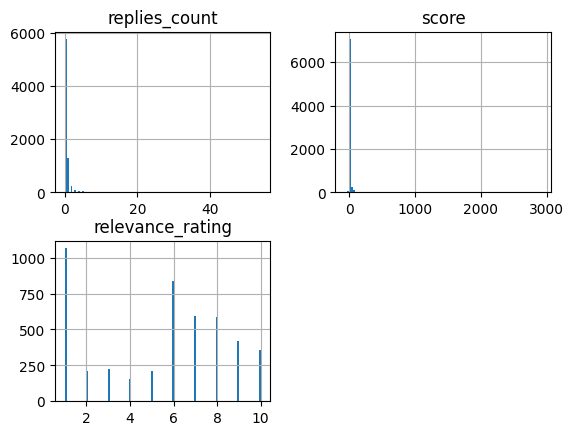

In [ ]:
#Continuous values
df.hist(bins = 100)
plt.show()

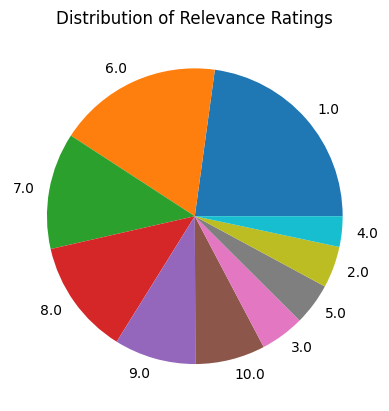

In [ ]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

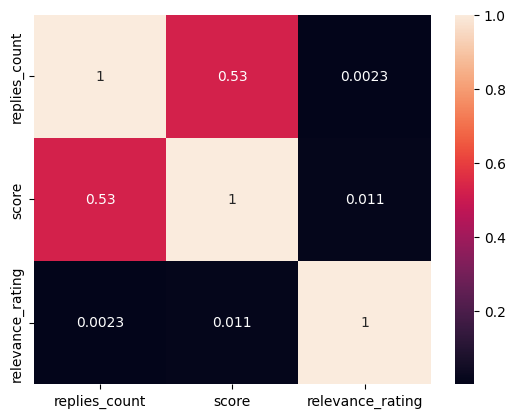

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [ ]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [ ]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

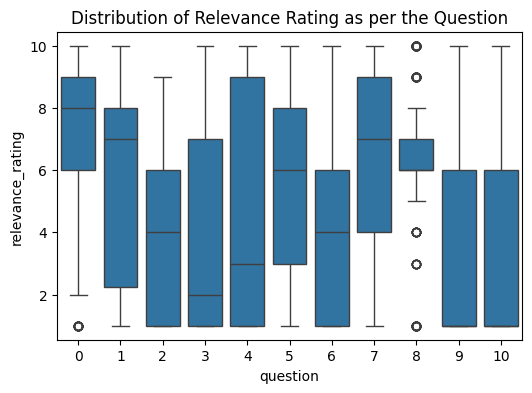

In [ ]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

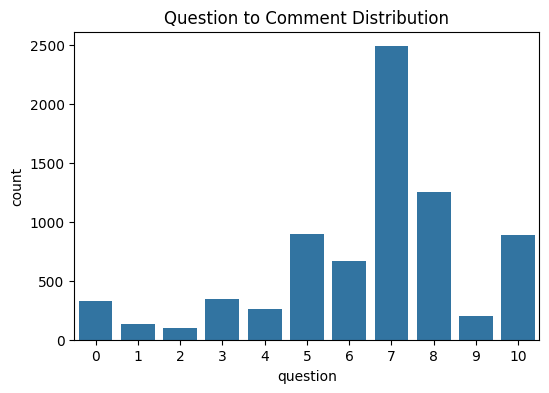

In [ ]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

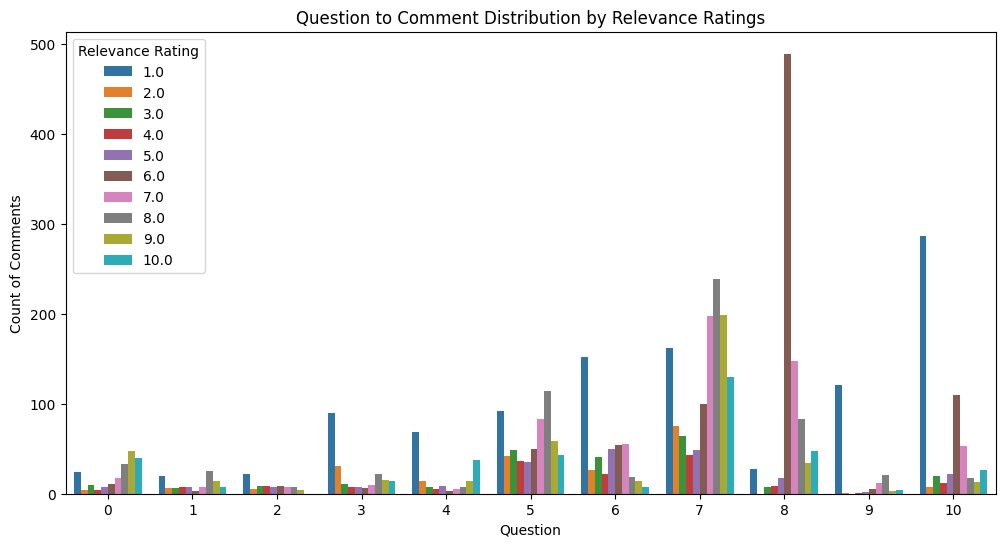

In [ ]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [ ]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []

    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]

        # User engagement factors: score and reply counts
        max_score = max(df_temp['score'])
        min_score = min(df_temp['score'])
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]

        max_replies = max(df_temp['replies_count'])
        min_replies = min(df_temp['replies_count'])
        normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]

        # Cluster coherence,semantic similarity
        coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)

        # Sentiment polarity of each comment
        sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
        max_sentiment = max(sentiments)
        min_sentiment = min(sentiments)
        normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

        # Calculate relevance score for the current cluster
        relevance_score = np.mean(normalized_scores) + np.mean(normalized_replies) + np.mean(normalized_sentiment) + np.mean(semantic_similarity) + coherence
        relevance_scores.append((str(key),relevance_score))

    relevances = [r for _, r in relevance_scores]
    max_relevance = max(relevances)
    min_relevance = min(relevances)
    normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]

    # Create a dictionary with comments as keys and normalized sentiments as values
    relevance_scores = dict(zip(topics.keys(), normalized_relevances))
    return relevance_scores

**Part 6 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now :

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be :
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations (hybrid models).

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_punctuation(text):
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)

#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_punctuation).str.lower()
df['question'] = df['question'].apply(remove_punctuation).str.lower()
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,question,comment,replies_count,score,relevance_rating
0,what do y’all think is the best iphone 15 pro ...,natural until they do colour matching with the...,0,1,7.0
1,what is your favourite game of all time,dishonored and outer wilds,0,1,6.0
2,what is the best question to ask on a job inte...,sounds like dodging a bullet i wouldnt want to...,9,317,NaN
3,what is a pokemon you love that isnt very popu...,noivern oh wait people do talk about it,0,2,5.0
4,what is the best question to ask on a job inte...,bullshit you’re hiring me to do a job my resea...,3,-4,NaN


Lets check the basic similarities between the question and replies and among replies as well.

In [ ]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

In [ ]:
question

'what do y’all think is the best iphone 15 pro max color'

In [ ]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
          0         1         2         3         4         5         6    \
0    1.000000  0.063540  0.016341  0.042096  0.022043  0.019196  0.012589   
1    0.063540  1.000000  0.122755  0.037749  0.140728  0.089242  0.139446   
2    0.016341  0.122755  1.000000  0.000000  0.074607  0.034909  0.271538   
3    0.042096  0.037749  0.000000  1.000000  0.044489  0.009151  0.000000   
4    0.022043  0.140728  0.074607  0.044489  1.000000  0.047092  0.084070   
..        ...       ...       ...       ...       ...       ...       ...   
893  0.056557  0.092861  0.000000  0.000000  0.000000  0.090427  0.177901   
894  0.021443  0.050286  0.009541  0.009979  0.055330  0.011208  0.048965   
895  0.020428  0.056370  0.037150  0.000000  0.153856  0.043642  0.028620   
896  0.037578  0.153939  0.080441  0.014849  0.088311  0.070566  0.053759   
897  0.000000  0.125617  0.024402  0.027770  0.042816  0.029067  0.105512   

          7         8         9    ...       888 

please do you have any idea which is the best colour for buying the iphone 15 pro max or 15 pro  and which colour model is the most selling on iphone 15 pro max  i am having this dilemma regarding the colour issue


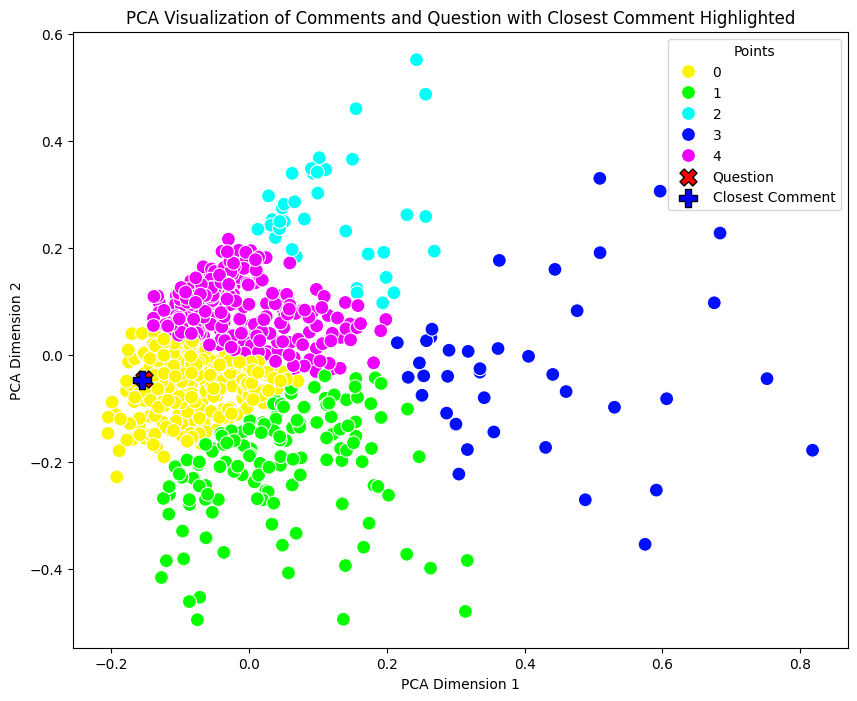

In [ ]:
# Re-constructing the TF-IDF matrix including the question and the comments together for better analysis
# Include the question as part of the texts
all_texts = np.append(comments, question )  # Include the question as part of the texts
all_texts

from sklearn.decomposition import PCA
# TF-IDF Vectorization including the question
vectorizer_all = TfidfVectorizer()
all_vectors = vectorizer_all.fit_transform(all_texts)

# Compute PCA for dimensionality reduction on the combined TF-IDF matrix
pca_model_all = PCA(n_components=2)
pca_results_all = pca_model_all.fit_transform(all_vectors.toarray())

# K-means clustering on the PCA-reduced data (including the question)
kmeans_all = KMeans(n_clusters=5, random_state=42)  # Assuming 2 clusters for better separation
cluster_labels_all = kmeans_all.fit_predict(pca_results_all)

question_cluster_label = cluster_labels_all[-1]

# Indices of comments in the same cluster as the question
same_cluster_indices = np.where(cluster_labels_all[:-1] == question_cluster_label)[0]  # Exclude the last index which is the question

# Compute distances from the question to each comment in the same cluster
distances = [euclidean(pca_results_all[-1], pca_results_all[idx]) for idx in same_cluster_indices]

# Find the index of the closest comment
closest_comment_index = same_cluster_indices[np.argmin(distances)]

# Extract the closest comment text
closest_comment = all_texts[closest_comment_index]
print(closest_comment)

# Visualization using a scatter plot for the clusters, highlighting the question and the closest comment
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(cluster_labels_all)))
scatter = sns.scatterplot(x=pca_results_all[:-1, 0], y=pca_results_all[:-1, 1], hue=cluster_labels_all[:-1],
                          palette=palette, style=cluster_labels_all[:-1], markers=['o'] * len(same_cluster_indices), s=100)

# Highlight the question
plt.scatter(pca_results_all[-1, 0], pca_results_all[-1, 1], color='red', s=150, edgecolors='k', marker='X', label='Question')

# Highlight the closest comment
plt.scatter(pca_results_all[closest_comment_index, 0], pca_results_all[closest_comment_index, 1],
            color='blue', s=150, edgecolors='k', marker='P', label='Closest Comment')

plt.title('PCA Visualization of Comments and Question with Closest Comment Highlighted')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Points')
plt.show()


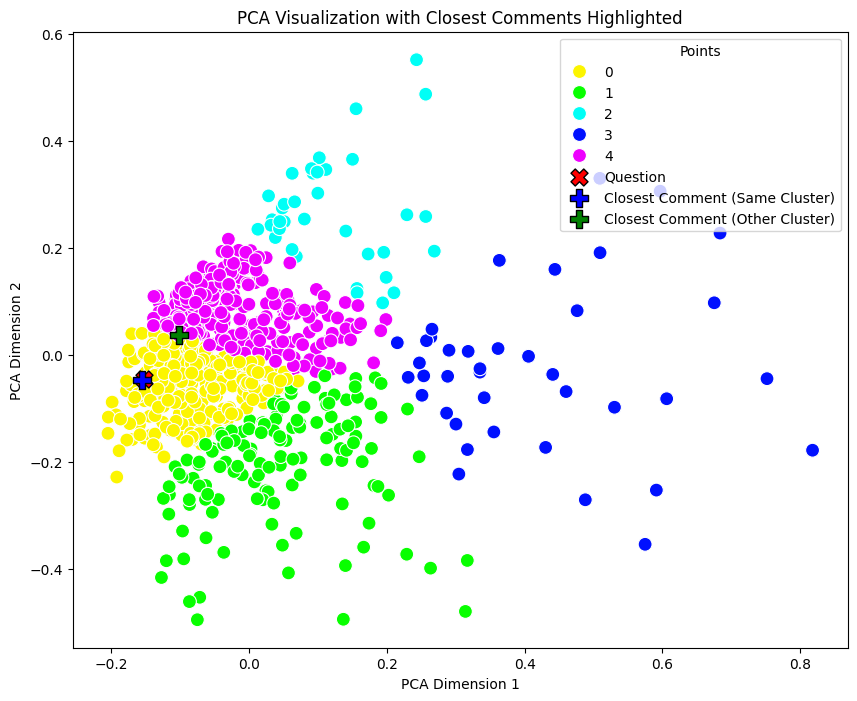

'this is the exact opposite of what my list would be'

In [ ]:
# Identify the cluster(s) that do not include the question
other_cluster_indices = np.where(cluster_labels_all[:-1] != question_cluster_label)[0]

# Compute distances from the question to each comment in the other cluster(s)
other_cluster_distances = [euclidean(pca_results_all[-1], pca_results_all[idx]) for idx in other_cluster_indices]

# Find the index of the closest comment in the other cluster
closest_comment_other_cluster_index = other_cluster_indices[np.argmin(other_cluster_distances)]

# Extract the closest comment text from the other cluster
closest_comment_other_cluster = all_texts[closest_comment_other_cluster_index]

# Visualization, highlighting the closest comment from the other cluster
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(cluster_labels_all)))
scatter = sns.scatterplot(x=pca_results_all[:-1, 0], y=pca_results_all[:-1, 1], hue=cluster_labels_all[:-1],
                          palette=palette, style=cluster_labels_all[:-1], markers=['o'] * len(same_cluster_indices), s=100)

# Highlight the question
plt.scatter(pca_results_all[-1, 0], pca_results_all[-1, 1], color='red', s=150, edgecolors='k', marker='X', label='Question')

# Highlight the closest comment from the same cluster
plt.scatter(pca_results_all[closest_comment_index, 0], pca_results_all[closest_comment_index, 1],
            color='blue', s=150, edgecolors='k', marker='P', label='Closest Comment (Same Cluster)')

# Highlight the closest comment from the other cluster
plt.scatter(pca_results_all[closest_comment_other_cluster_index, 0], pca_results_all[closest_comment_other_cluster_index, 1],
            color='green', s=150, edgecolors='k', marker='P', label='Closest Comment (Other Cluster)')

plt.title('PCA Visualization with Closest Comments Highlighted')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Points')
plt.show()

closest_comment_other_cluster


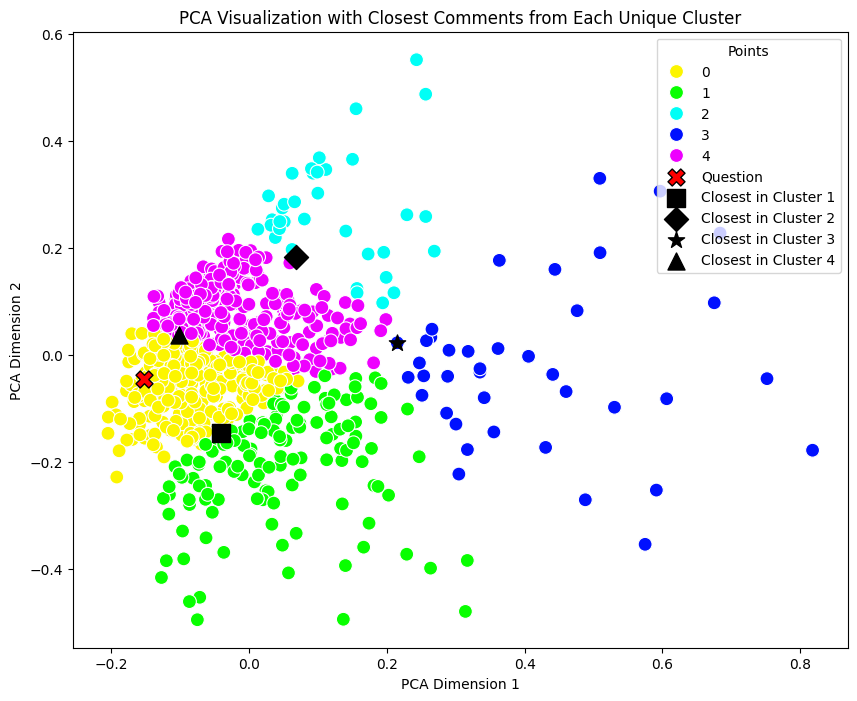

{'Cluster 1': 'i got the black 15 pro love the color the blue is nice too but i have a blue aw s6 and after three years now i kind of get bored by the color since i want to use my 15 pro for several years i wanted to play it safe and black is timeless my second option would be natural titanium but i had a white phone before and wanted a dark color',
 'Cluster 2': 'i got black facewithtearsofjoysmilingfacewithheartsgrimacingface',
 'Cluster 3': 'natural titanium is the best pick this year practically speaking but i love black phones so black titanium is my personal favorite',
 'Cluster 4': 'this is the exact opposite of what my list would be'}

In [ ]:
# Recalculate the unique clusters from the clustering results excluding the question
unique_clusters = np.unique(cluster_labels_all[:-1])  # All clusters from the dataset

# Determine the clusters different from the one containing the question
other_clusters = [cluster for cluster in unique_clusters if cluster != question_cluster_label]

# Dictionary to store the closest comment index for each other cluster
closest_comments_other_clusters = {}

# Find the closest comment in each of the other clusters
for cluster in other_clusters:
    cluster_indices = np.where(cluster_labels_all[:-1] == cluster)[0]
    cluster_distances = [euclidean(pca_results_all[-1], pca_results_all[idx]) for idx in cluster_indices]
    closest_index = cluster_indices[np.argmin(cluster_distances)]
    closest_comments_other_clusters[cluster] = closest_index

# Visualization with corrected cluster information and handling
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(unique_clusters))
scatter = sns.scatterplot(x=pca_results_all[:-1, 0], y=pca_results_all[:-1, 1], hue=cluster_labels_all[:-1],
                          palette=palette, s=100)

# Highlight the question
plt.scatter(pca_results_all[-1, 0], pca_results_all[-1, 1], color='red', s=150, edgecolors='k', marker='X', label='Question')

# Highlight the closest comments from other clusters
markers = ['P', 's', 'D', '*', '^']  # Assign unique markers for each cluster
for cluster, index in closest_comments_other_clusters.items():
    plt.scatter(pca_results_all[index, 0], pca_results_all[index, 1],
                color='black', s=150, edgecolors='k', marker=markers[cluster], label=f'Closest in Cluster {cluster}')

plt.title('PCA Visualization with Closest Comments from Each Unique Cluster')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Points')
plt.show()

# Return the closest comments text from each other cluster
{f"Cluster {cluster}": all_texts[index] for cluster, index in closest_comments_other_clusters.items()}


In [ ]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (79, 725) Similarity Score: 1.0000000000000004
natural all day 
and
 natural all day
--------------------------------------
Pair: (49, 197) Similarity Score: 1.0000000000000002
natural titanium 
and
 natural titanium
--------------------------------------
Pair: (49, 322) Similarity Score: 1.0000000000000002
natural titanium 
and
 natural titanium
--------------------------------------
Pair: (49, 700) Similarity Score: 1.0000000000000002
natural titanium 
and
 natural titanium
--------------------------------------
Pair: (197, 322) Similarity Score: 1.0000000000000002
natural titanium 
and
 natural titanium
--------------------------------------


In [ ]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (223, 224) Similarity Score: 0.4623933105599206
please do you have any idea which is the best colour for buying the iphone 15 pro max or 15 pro  and which colour model is the most selling on iphone 15 pro max  i am having this dilemma regarding the colour issue 
and
 the purple is the sexiest in the land
--------------------------------------
Pair: (223, 225) Similarity Score: 0.4623933105599206
please do you have any idea which is the best colour for buying the iphone 15 pro max or 15 pro  and which colour model is the most selling on iphone 15 pro max  i am having this dilemma regarding the colour issue 
and
 color is so subjective if you prefer dark phones the blue is the one to get if you like light phones flip a coin as both natural and titanium are gorgeous but will appeal to different people
--------------------------------------
Pair: (223, 226) Similarity Score: 0.4623933105599206
please do you have any idea which is the best colour for buying the ip

In [ ]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[599 601 597 600 596 598]]
Most similar sentence to 'what do y’all think is the best iphone 15 pro max color'
i went with a case for protection lol i think if anyone buys one of these phones and doesn’t get a case then you’re asking for your phone to break so far my iphone looks brand new still no complaints i take good care of it and make sure i don’t misplace it or drop it


black fire


the colors all look like someone’s fridge to me but i do think the blue matches with my mac book air however i’ve gone to my local phone store and all the dark colors had their paint jobs scratched up by people just playing with them so id recommend a lighter color maybe the off white


blue and black natural is good for future proofing against scratches but its kind of boring


original titanium for sure i have the black one it looks cheap and common do not make my mistake


natty looks soooo smooth




In [ ]:
num_topics = 5
kmeans_tfidf = KMeans(n_clusters=num_topics)
kmeans_tfidf.fit(comment_vectors)

# Assign each comment to a cluster
cluster_labels_tfidf = kmeans_tfidf.labels_

cluster_embeddings_tfidf = defaultdict(list)
for i, comment_embedding in enumerate(comment_vectors):
    cluster_label = cluster_labels_tfidf[i]
    cluster_embeddings_tfidf[cluster_label].append(comment_embedding.toarray())
cluster_embeddings_tfidf = dict(cluster_embeddings_tfidf)

# Print comments belonging to each cluster (topic)
topics_tfidf = {}
for i, comment in enumerate(comments):
    if cluster_labels_tfidf[i] not in topics_tfidf:
        topics_tfidf[cluster_labels_tfidf[i]] = []
    topics_tfidf[cluster_labels_tfidf[i]].append(comment)

In [ ]:
filtered_data = {key: value[:4] for key, value in topics_tfidf.items()}
pd.DataFrame(filtered_data)

,3,4,2,1,0
0,natural until they do colour matching with the...,ive got the natural titanium after seeing yout...,blue but the grey is cool too,natural titanium and the almost white thingy,i love black
1,do i come to your house and shit in your cerea...,blue cause its the one that was in stock when ...,i got blue it’s my favorite i had the blue 13p...,natural,matte black
2,blu,i got a case i am currently using the fine wov...,i got the blue but i love natural titanium tha...,natural all the way,black or white help
3,yes sir same here,i’d go with the black but heard it wears off e...,i have the blue and love it i did consider the...,i got my wife the natural titanium color she l...,black or blue


In [ ]:
# Re-constructing the TF-IDF matrix including the question and the comments together for better analysis
# all_texts = np.append(question1df['comment'].values, question1df['question'][0] )  # Include the question as part of the texts

from sklearn.decomposition import PCA
# TF-IDF Vectorization including the question
vectorizer_all = TfidfVectorizer()
all_vectors = vectorizer_all.fit_transform(all_texts)

# Compute PCA for dimensionality reduction on the combined TF-IDF matrix
pca_model_all = PCA(n_components=2)
pca_results_all = pca_model_all.fit_transform(all_vectors.toarray())

# K-means clustering on the PCA-reduced data (including the question)
kmeans_all = KMeans(n_clusters=5, random_state=42)  # Assuming 2 clusters for better separation
cluster_labels_all = kmeans_all.fit_predict(pca_results_all)

# Visualization using a scatter plot for the clusters, highlighting the question
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(cluster_labels_all)))
sns.scatterplot(x=pca_results_all[:, 0], y=pca_results_all[:, 1], hue=cluster_labels_all, palette=palette, s=100)

# Highlight the question point
plt.scatter(pca_results_all[-1, 0], pca_results_all[-1, 1], color='red', s=150, edgecolors='k', marker='X')
plt.title('PCA Visualization of Comments and Question')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Cluster', labels=['label1','label2','label3','label4','label5'], loc='best')
plt.show()

In [ ]:
# relevance_scores_tfidf = calculate_relevance_scores(question1df,question_vectors,cluster_embeddings_tfidf,topics_tfidf,'tfidf')
# print("Relevance Scores for Each Cluster:", relevance_scores_tfidf)

- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [ ]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  what do y’all think is the best iphone 15 pro max color
Relevant comments:
- i got the blue but love the natural a piece of me wishes i had gotten the natural but tbh i’m super happy with the blue 0.9999971975849481
- my wife has the pacific blue 12pm so i went natural ti absolute gorgeous 0.9999962258039531
- blue it’s the best color iphone has had ever tbh but the 14pm purple is a dope second 0.9999914009923306
- love the natural titanium this is my 8th iphone and the first nonblack option ive ever opted for no regrets 0.9999852481918763
- white is the way to go this year had the same experience first liked the natural then saw the colors in real life and went with white no regrets looks incredible 0.9999831863242452
- i got the regret but i fuggin love the titanium that being said i don’t regret my regret 0.9999829894299047
- white the best imo natural titanium is overrated looks like a gold iphone or a macbook from a decade ago 0.9999766689047959
- i got the iphone but 

Observations :
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

In [ ]:
num_topics = 5
kmeans_lda = KMeans(n_clusters=num_topics)
kmeans_lda.fit(comment_topics)

# Assign each comment to a cluster
cluster_labels_lda = kmeans_lda.labels_

cluster_embeddings_lda = defaultdict(list)
for i, comment_embedding in enumerate(comment_topics):
    cluster_label = cluster_labels_lda[i]
    cluster_embeddings_lda[cluster_label].append(comment_embedding)
cluster_embeddings_lda = dict(cluster_embeddings_lda)
# Print comments belonging to each cluster (topic)
topics_lda = {}
for i, comment in enumerate(comments):
    if cluster_labels_lda[i] not in topics_lda:
        topics_lda[cluster_labels_lda[i]] = []
    topics_lda[cluster_labels_lda[i]].append(comment)

In [ ]:
filtered_data = {key: value[:3] for key, value in topics_lda.items()}
pd.DataFrame(filtered_data)

,0,1,2,4,3
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,emboar there i said it,spheal so round pleadingface
1,heracross is my number 3 favorite,i both love palossand and get creeped out by p...,hes a monster in pokémon go pvp,volbeat my first shiny was a volbeat and i hav...,love me spheal rolley little ball 3
2,skitty is super strong in mystery dungeon,so cool and cute shields down is a fun mechani...,i love avalugg,dunsparce is one of my favorites,buizel


In [ ]:
# relevance_scores_lda = calculate_relevance_scores(question1df,question_topic,cluster_embeddings_lda,topics_lda,'lda')
# print("Relevance Scores for Each Cluster:", relevance_scores_lda)

- **Pre-trained models** (Transfer Learning)

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

cluster_embeddings = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings):
    cluster_label = cluster_labels[i]
    cluster_embeddings[cluster_label].append(comment_embedding)
cluster_embeddings = dict(cluster_embeddings)
# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [ ]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,4,3,0,2,1
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,i both love palossand and get creeped out by p...,hes a monster in pokémon go pvp,i adore breloom because of one piece but nobod...
1,weezing,so cool and cute shields down is a fun mechani...,volbeat my first shiny was a volbeat and i hav...,impadimp legit never loved a pokemon as much,loved nidoking until i realized he was a tiny ...
2,emboar there i said it,regular pinsir is overlooked by a majority of ...,dunsparce is one of my favorites,skitty is super strong in mystery dungeon,kommoo great design unique typing but has a ba...
3,based on friends reactions id say azumarill an...,skitty and delcatty ate very underrated but ha...,i love avalugg,joltik i think 75 of the bug pokémon are reall...,celebi i know she kinda popular but she one of...


In [ ]:
relevance_scores = calculate_relevance_scores(question1df,question_embedding,cluster_embeddings,topics,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores)

Relevance Scores for Each Cluster: {4: 0.0, 3: 0.45043085306907515, 0: 0.6757340282681056, 2: 1.0, 1: 0.5557019104298013}


- **Pre-trained models (Another version or Bert)**

In [ ]:
comments.shape

(2491,)

In [ ]:
model2 = SentenceTransformer('vinai/bertweet-base', device='cpu')
comment_embeddings_m2 = []
for comment in comments:
    if len(comment) > model2.max_seq_length:
       comment = comment[:model2.max_seq_length]
    comment_embedding = model2.encode(comment)
    comment_embeddings_m2.append(torch.from_numpy(comment_embedding))
comment_embeddings_m2 = torch.stack(comment_embeddings_m2)
question_embedding_m2 = model2.encode(question)

num_topics = 5
kmeans2 = KMeans(n_clusters=num_topics)
kmeans2.fit(comment_embeddings_m2)
cluster_labels_m2 = kmeans2.labels_

cluster_embeddings_m2 = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_m2):
    cluster_label = cluster_labels_m2[i]
    cluster_embeddings_m2[cluster_label].append(comment_embedding)
cluster_embeddings_m2 = dict(cluster_embeddings_m2)

topics2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_m2[i] not in topics2:
        topics2[cluster_labels_m2[i]] = []
    topics2[cluster_labels_m2[i]].append(comment)

No sentence-transformers model found with name vinai/bertweet-base. Creating a new one with MEAN pooling.


In [ ]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,2,1,0
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,so cool and cute shields down is a fun mechani...,emboar there i said it
1,spheal so round pleadingface,i both love palossand and get creeped out by p...,chanseyyyyy,regular pinsir is overlooked by a majority of ...,hes a monster in pokémon go pvp
2,love me spheal rolley little ball 3,volbeat my first shiny was a volbeat and i hav...,luxray,skitty and delcatty ate very underrated but ha...,dunsparce is one of my favorites
3,bannett and trubbish,i adore breloom because of one piece but nobod...,ampharos,based on friends reactions id say azumarill an...,i love avalugg


In [ ]:
relevance_scores_m2 = calculate_relevance_scores(question1df,question_embedding_m2,cluster_embeddings_m2,topics2,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_m2)

Relevance Scores for Each Cluster: {4: 0.6516263073107756, 3: 0.9724212981405435, 2: 0.0, 1: 1.0, 0: 0.7122373506242359}


- **LSTM model**

In [ ]:
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(comments)
sequences = tokenizer_lstm.texts_to_sequences(comments)
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Model hyperparameters
embedding_dim = 50
# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=64))

# Compile the model (not necessary if you're not training)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get embeddings
comment_embeddings_lstm = model_lstm.predict(padded_sequences)

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step


In [ ]:
tokenizer_lstm.fit_on_texts([question])
sequence = tokenizer_lstm.texts_to_sequences([question])
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = len(sequence[0])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
question_embeddings_lstm = model_lstm.predict(padded_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


In [ ]:
num_topics = 5
kmeans_lstm = KMeans(n_clusters=num_topics)
kmeans_lstm.fit(comment_embeddings_lstm)

# Assign each comment to a cluster
cluster_labels_lstm = kmeans_lstm.labels_

cluster_embeddings_lstm = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_lstm):
    cluster_label = cluster_labels_lstm[i]
    cluster_embeddings_lstm[cluster_label].append(comment_embedding)
cluster_embeddings_lstm = dict(cluster_embeddings_lstm)
# Print comments belonging to each cluster (topic)
topics_lstm = {}
for i, comment in enumerate(comments):
    if cluster_labels_lstm[i] not in topics_lstm:
        topics_lstm[cluster_labels_lstm[i]] = []
    topics_lstm[cluster_labels_lstm[i]].append(comment)

In [ ]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,4,3,2,1,0
0,frillish and both stunfisks,i caught a wild delcatty in a randomized plati...,weezing,so cool and cute shields down is a fun mechani...,emboar there i said it
1,spheal so round pleadingface,i both love palossand and get creeped out by p...,chanseyyyyy,regular pinsir is overlooked by a majority of ...,hes a monster in pokémon go pvp
2,love me spheal rolley little ball 3,volbeat my first shiny was a volbeat and i hav...,luxray,skitty and delcatty ate very underrated but ha...,dunsparce is one of my favorites
3,bannett and trubbish,i adore breloom because of one piece but nobod...,ampharos,based on friends reactions id say azumarill an...,i love avalugg


In [ ]:
relevance_scores_lstm = calculate_relevance_scores(question1df,question_embeddings_lstm,cluster_embeddings_lstm,topics_lstm,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_lstm)

ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.